# Example 02: Full Workflow (Qubit)

## Synopsis

This notebook exemplifies usage of `dwdynamics` library with complex systems (as opposed to real ones, treated in our original paper).

The steps in this notebook are the same as in Example 01, except this time we are encoding both real and imaginary component of evolution.
Differences between this example and Example 01 will be clearly pointed out.

To keep the number of logical variables the same, we will be using only 3 time points.

## 1. Defining the problem

In [1]:
import numpy as np
from dwdynamics import ComplexDynamicsProblem, Objective # Difference a. We are using ComplexDynamicsProblem
# We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...
SY = np.array([[0, -1.0j], [1.0j, 0.0]])
PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.

# The problem object encapsulates all the data so you don't have to pass them around
problem = ComplexDynamicsProblem(
    hamiltonian=0.5 * np.pi * SY,      # Evolution under hamiltonian 0.5 * np.pi * sigma_y
    initial_state = PSI0,              # Starting at initial state |0>,
    times=tuple(range(3)),             # With six time points 0,1,2
    num_bits_per_var=2                 # And two bits of precision per variable
)

## 2. Creating QUBO for the problem

In [2]:
qubo = problem.qubo(objective=Objective.norm)  # Other choice would be to use Objective.hessian

In [3]:
# Sanity check 1: total number of QUBO variables is:
# num_vars = dimension of system * number of time points * number of bits per variable * 2
# Difference c.: Number of variables is multiplied x2 because we are using complex numbers
assert qubo.num_variables == problem.hamiltonian.shape[0] * len(problem.times) * problem.num_bits_per_var * 2

## 3a. Solving using Dimod's exact solver
Since system size is small (24 bits), we can use an exact solver to find the ground state.

In [4]:
from dimod import ExactSolver

exact_solver = ExactSolver()

exact_result = exact_solver.sample(qubo)

In [5]:
# Sanity check 2: solution should be exact, and so the energy should be 0
# Note that this is only the case for default, norm-based objective.
# For hessian-based objective the energy might be nonzero.
assert exact_result.first.energy == 0.0

## 3b. Solving using Dimod's Simulated Annealing Sampler

In [6]:
from dimod import SimulatedAnnealingSampler

sa_sampler = SimulatedAnnealingSampler()

sa_result = sa_sampler.sample(qubo, num_reads=50)

sa_result.first.energy

np.float64(0.0)

## 3c. Solving using an actual D-Wave machine

In [7]:
import os
from dwave.system import DWaveSampler, EmbeddingComposite

DW_TOKEN = os.getenv("DW_TOKEN")  # <- Place your token here, or use DW_TOKEN env variable, or configure D-Wave libraries to use config file

# The graph fo the problem is pretty dense, we use automatic embedding to mitigate the incompatibility with actual machine
dw_sampler = EmbeddingComposite(DWaveSampler(token=DW_TOKEN))

dw_result = dw_sampler.sample(qubo, num_reads=1000, annealing_time=200)

dw_result.first.energy

np.float64(1.0)

## 4. Interpreting the results
As in the original experiment, we use $\langle \sigma_z \rangle$. The exact dynamics will be computed using Qutip.

In [8]:
# Let's compute baseline using QuTiP
import qutip as qp

H_qp = 0.5 * np.pi * qp.sigmay()

psi_0 = qp.basis(2, 0)
times = np.linspace(0, 2, 100)
baseline = qp.mesolve(H_qp, psi_0, times, e_ops=[qp.sigmaz()]).expect[0]

In [9]:
# Define sigma_z for manual computation of expected values
SZ = np.array([[1, 0], [0, -1]])

# decode_sample returns flat vector, we use reshape to form an 6x2 array of states
exact_vec = problem.interpret_sample(exact_result.first.sample)

# Difference d.: We use complex conjugation to compute expected values. For this example it shouldn't matter though.
# Then, for the expectation values we take only the real part, because otherwise matplotlib would complain.
exact_expect = [(state.conj() @ SZ @ state).real for state in exact_vec]

# SA and D-Wave results get the same treatment
sa_vec = problem.interpret_sample(sa_result.first.sample)
sa_expect = [(state.conj() @ SZ @ state).real for state in sa_vec]

dw_vec = problem.interpret_sample(dw_result.first.sample)
dw_expect = [(state.conj() @ SZ @ state).real for state in dw_vec]

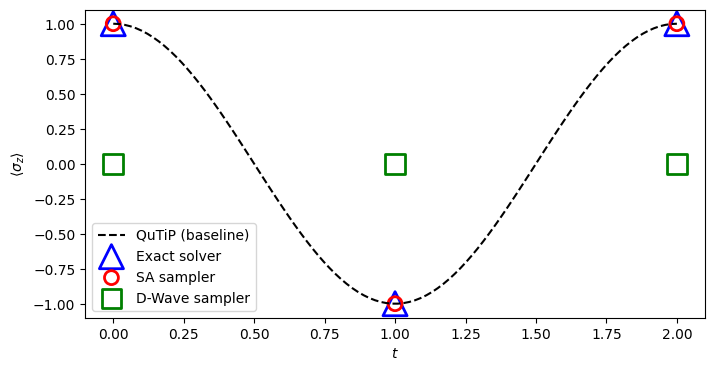

In [10]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots(figsize=(8, 4))

axis.plot(times, baseline, "k--", label="QuTiP (baseline)")

axis.scatter(problem.times, exact_expect, marker="^", lw=2, s=300, edgecolors="b", facecolors="none", label="Exact solver")
axis.scatter(problem.times, sa_expect, marker="o", lw=2, s=100, edgecolors="r", facecolors="none", label="SA sampler")
axis.scatter(problem.times, dw_expect, marker="s", lw=2, s=200, edgecolors="g", facecolors="none", label="D-Wave sampler")

axis.set_ylabel(r"$\langle \sigma_z \rangle$")
axis.set_xlabel("$t$")
axis.legend()